# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## Загрузка данных

### Прописываем пути

In [3]:
trainf = "train.csv"
testf = "test.csv"

### Загружаем данные в память

In [4]:
train_df = pd.read_csv(trainf)
test_df = pd.read_csv(testf)

### Описание данных
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

### Уменьшение объема памяти, который занимает датасет

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [7]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


## Обработка данных

In [8]:
class DataPreprocessor():
    def __init__(self):
        self.min_max_floor_msk = (1, 95) # ВМоскве нет домов выше 95 этажей
        self.min_life_square = 14 # Жилая площадь не может быть менее 14 кв.м. согласно законодательству
        self.min_kitchen_square = 5
        self.max_rooms = 5
        self.median_year = None
        self.max_floor_for_district = None
        self.pivot_rooms = None # сводная таблица медиан этажей по годам
        self.filter_square = None # фильтр для площадей в которые верим
        self.pivot_square = None # сводная таблица площадей по годам
        self.pivot_lsquare = None # сводная долей жилых площадей от общей площади по числу комнат
        self.pivot_ksquare = None # сводная долей кухонных площадей от общей площади по числу комнат
        self.districts_healthcare = None
        self.medians = None
        
    def fit(self, df):
        
        # Приводим в порядок года
        self.median_year = df.loc[df.HouseYear < datetime.now().year].\
            pivot_table(values="HouseYear", index="DistrictId", columns="HouseFloor", aggfunc=np.median)
        self.transform_year(df)
        
        # Приводим в порядок этажи
        self.max_floor_for_district = df.loc[df.HouseFloor < self.min_max_floor_msk[1]].\
            pivot_table(values="HouseFloor", index="DistrictId", columns="HouseYear", aggfunc=np.max)
        self.transform_floor(df)
        
        # Приводим в порядок комнаты
        filter_rooms = (df.Square > df.LifeSquare) & (df.Square > df.KitchenSquare) &\
                (df.LifeSquare > df.KitchenSquare) & (df.Rooms <= self.max_rooms) & \
                ((df[["Square", "LifeSquare", "KitchenSquare", "Rooms"]] > 0).all(axis=1))
        
        self.pivot_rooms = df.loc[filter_rooms].\
            pivot_table(index="Rooms", columns="HouseYear", values="Square", aggfunc=np.median)

        for r, row in self.pivot_rooms.iterrows():
            for y in row.index[row.isnull()].tolist():
                dif = np.abs(row.index[~row.isnull()] - y).tolist()
                new_y = row.index[~row.isnull()][dif.index(np.min(dif))]
                self.pivot_rooms.loc[r, y] = self.pivot_rooms.loc[r, new_y]
        self.trainsform_room(df)
        
        # Приводим в порядок площадь
        self.filter_square = "(df.Square > df.LifeSquare) & (df.Square > df.KitchenSquare) &\
            (df.KitchenSquare != 0) & (df.Square >= df.LifeSquare + df.KitchenSquare) &\
            (df.LifeSquare >= self.min_life_square) & (df.KitchenSquare >= self.min_kitchen_square) &\
            (df.LifeSquare > df.Square - df.LifeSquare - df.KitchenSquare)"
        
        self.pivot_square = df.loc[eval(self.filter_square)].\
            pivot_table(index="Rooms", columns="HouseYear", values="Square", aggfunc=[np.min, np.max, np.median])
        
        for foo in ("amin", "amax", "median"):
            for r, row in self.pivot_square.loc[:, foo].iterrows():
                for y in row.index[row.isnull()].tolist():
                    dif = np.abs(row.index[~row.isnull()] - y).tolist()
                    new_y = row.index[~row.isnull()][dif.index(np.min(dif))]
                    self.pivot_square.loc[r, (foo, y)] = self.pivot_square.loc[r, (foo, new_y)]
        
        self.pivot_lsquare = df.loc[eval(self.filter_square)]
        self.pivot_lsquare.loc[:, "div"] = (self.pivot_lsquare.loc[:, "Square"] / self.pivot_lsquare.loc[:, "LifeSquare"])
        self.pivot_lsquare = self.pivot_lsquare.pivot_table(index="Rooms", columns="HouseYear", values="div", aggfunc="median")
        
        for r, row in self.pivot_lsquare.iterrows():
            for y in row.index[row.isnull()].tolist():
                dif = np.abs(row.index[~row.isnull()] - y).tolist()
                new_y = row.index[~row.isnull()][dif.index(np.min(dif))]
                self.pivot_lsquare.loc[r, y] = self.pivot_lsquare.loc[r, new_y]
                
        self.pivot_ksquare = df.loc[eval(self.filter_square)]
        self.pivot_ksquare.loc[:, "div"] = self.pivot_ksquare.loc[:, "Square"] / self.pivot_ksquare.loc[:, "KitchenSquare"]
        self.pivot_ksquare = self.pivot_ksquare.pivot_table(index="Rooms", columns="HouseYear", values="div", aggfunc="median")
        
        for r, row in self.pivot_ksquare.iterrows():
            for y in row.index[row.isnull()].tolist():
                dif = np.abs(row.index[~row.isnull()] - y).tolist()
                new_y = row.index[~row.isnull()][dif.index(np.min(dif))]
                self.pivot_ksquare.loc[r, y] = self.pivot_ksquare.loc[r, new_y]
        
        self.transform_square
        
        # Healthcare_1
        
        self.districts_healthcare =\
            df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        
           
    def transform(self, df):
        
        # Приводим в порядок года
        df = self.transform_year(df)
        
        # Приводим в порядок этажи
        df = self.transform_floor(df)
        
        # Приводим в порядок комнаты
        df = self.trainsform_room(df)
        
        # Приводим в порядок площадь
        df = self.transform_square(df)
        
        # Бнаризация экологических показателей и магазинов
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # Приводим в порядок показатель здравоохранения
        self.medians = df.median()
             
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
    
        
        return df
    
    def transform_year(self, df):
        for i, row in df.loc[df.HouseYear > datetime.now().year].iterrows():
            df.loc[i, "HouseYear"] = round(self.median_year.loc[row.loc["DistrictId"], row.loc["HouseFloor"]])
        
        return df
    
    def transform_floor(self, df):
        for i, row in df.loc[(df.HouseFloor > self.min_max_floor_msk[1]) | (df.HouseFloor == 0)].iterrows():
            df.loc[i, "HouseFloor"] = self.max_floor_for_district.loc[row.loc["DistrictId"], row.loc["HouseYear"]] or \
               self.max_floor_for_district.loc[row.loc["DistrictId"]-4:row.loc["DistrictId"]+4,\
                                            row.loc["HouseYear"]-4:row.loc["HouseYear"]+4].max().max()
            
            df.loc[df.HouseFloor.isnull(), "HouseFloor"] =\
            self.max_floor_for_district.loc[row.loc["DistrictId"]].median()
            
        df.loc[(df.HouseFloor < df.Floor), ["HouseFloor", "Floor"]] =\
            df.loc[(df.HouseFloor < df.Floor), ["Floor", "HouseFloor"]].values
                        
        return df
    
    def trainsform_room(self, df):
        for i, row in df.loc[(df.Rooms == 0) | (df.Rooms > self.max_rooms)].iterrows():
            df.loc[i, "Rooms"] =\
                (self.pivot_rooms.loc[:, row["HouseYear"]] - row["Square"]).\
                 abs().sort_values().index[0]
            
        return(df)
    
    def transform_square(self, df):
        df.Square, df.LifeSquare = np.where((df.Square < df.LifeSquare) &\
                                                (1.5*df.Square >= df.LifeSquare ),\
                                                (df.LifeSquare, df.Square), (df.Square, df.LifeSquare))
        
        for r in df.loc[~eval(self.filter_square)].Rooms.unique():
            for y in df.loc[~eval(self.filter_square)].HouseYear.unique():
                if y not in self.pivot_square.loc[r, "amin"].index:             
                    dif = np.abs(self.pivot_square.loc[r, "amin"].index - y).tolist()
                    y1 = self.pivot_square.loc[r, "amin"].index[dif.index(np.min(dif))]
                else:
                    y1 = y
                    
                flt = (df.Rooms == r) & (df.HouseYear == y) & (df.Square < self.pivot_square.loc[r, ("amin", y1)])
                df.loc[flt, "Square"] = self.pivot_square.loc[r, ("median", y1)]
                flt = (df.Rooms == r) & (train_df.HouseYear == y) & (df.Square > self.pivot_square.loc[r, ("amax", y1)])
                df.loc[flt, "Square"] = self.pivot_square.loc[r, ("median", y1)]
                
                flt = (df.Rooms == r) & (df.HouseYear == y) &\
                             ((df.Square < df.LifeSquare) |\
                              df.LifeSquare.isnull() |\
                              (df.LifeSquare < self.min_life_square))
                df.loc[flt, "LifeSquare"] = df.loc[flt, "Square"] / self.pivot_lsquare.loc[r, y1]
                flt = (df.Rooms == r) & (df.HouseYear == y) &\
                             ((df.Square < df.LifeSquare) |\
                              df.LifeSquare.isnull() |\
                              (df.LifeSquare > self.pivot_lsquare.loc[r].max()))
                df.loc[flt, "LifeSquare"] = df.loc[flt, "Square"] / self.pivot_lsquare.loc[r, y1]
                
                flt = (df.Rooms == r) & (df.HouseYear == y) &\
                       ((df.Square < df.KitchenSquare) |\
                        (df.KitchenSquare == 0) |\
                        (df.KitchenSquare < 5))
                df.loc[flt, "KitchenSquare"] = df.loc[flt, "Square"] / self.pivot_ksquare.loc[r, y1]
                flt = (df.Rooms == r) & (df.HouseYear == y) &\
                       ((df.Square < df.KitchenSquare) |\
                        (df.KitchenSquare == 0) |\
                        (df.KitchenSquare > self.pivot_ksquare.loc[r].max()))
                df.loc[flt, "KitchenSquare"] = df.loc[flt, "Square"] / self.pivot_ksquare.loc[r, y1]
        
        return(df)



In [9]:
class FeatureGenerator:
    def __init__(self):
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None
        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median') 
        
    def transform(self, df):
        df["div_square"] = df.Square / (df.LifeSquare + df.KitchenSquare)
        
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)    
        
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 
                
        return df
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        return(df)
    

Сделаем столбец "Id" индексом, т.к. он уникален для каждого набора данных

In [10]:
train_df.Id.size - train_df.Id.unique().size

0

In [11]:
test_df.Id.size - test_df.Id.unique().size

0

In [12]:
train_df.set_index("Id", inplace=True)

In [13]:
test_df.set_index("Id", inplace=True)

Преобразование данных

In [14]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

/tmp/ipykernel_54021/2204803009.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.pivot_lsquare.loc[:, "div"] = (self.pivot_lsquare.loc[:, "Square"] / self.pivot_lsquare.loc[:, "LifeSquare"])
/tmp/ipykernel_54021/2204803009.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.pivot_ksquare.loc[:, "div"] = self.pivot_ksquare.loc[:, "Square"] / self.pivot_ksquare.loc[:, "KitchenSquare"]
/tmp/ipykernel_54021/2204803009.py:109: FutureWarning: The default value of numeric_only in DataFrame.median is

In [15]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.transform(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.transform(test_df)

/tmp/ipykernel_54021/999425575.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), xticklabels=train_df.corr().columns,\
/tmp/ipykernel_54021/999425575.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  yticklabels=train_df.corr().columns, cmap='coolwarm', center=0, annot=True,\
/tmp/ipykernel_54021/999425575.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask=np.triu(train_df.corr()), cbar_kws= {'orientation': 'horizontal'})


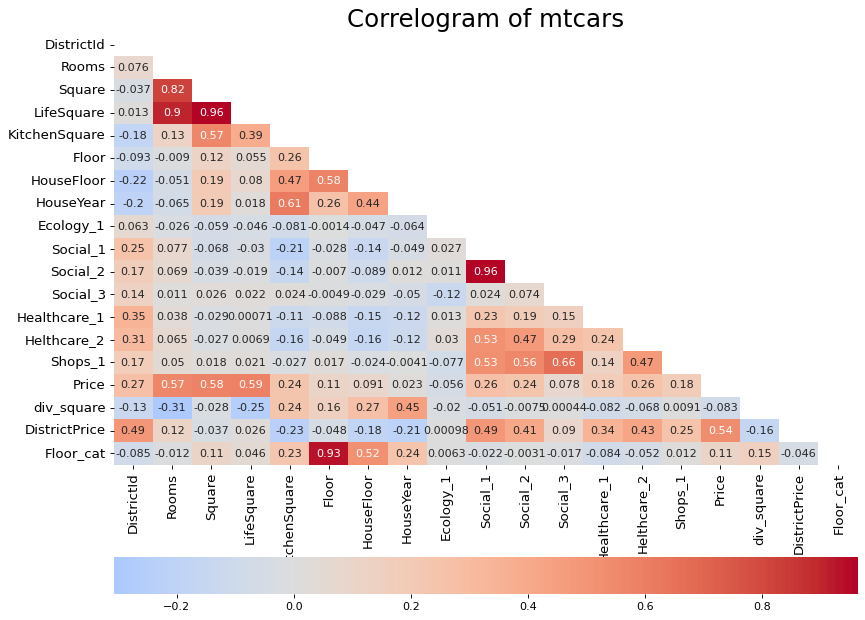

In [16]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(train_df.corr(), xticklabels=train_df.corr().columns,\
            yticklabels=train_df.corr().columns, cmap='coolwarm', center=0, annot=True,\
           mask=np.triu(train_df.corr()), cbar_kws= {'orientation': 'horizontal'})

# Decorations
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [17]:
X_train, X_test, y_train, y_test =\
    train_test_split(train_df.drop(["Price",], axis=1), train_df.loc[:, "Price"],
                     test_size=0.15, shuffle=True, random_state=42)

R2:	0.871
RMSE:	32941.925
MSE:	1085170400.718


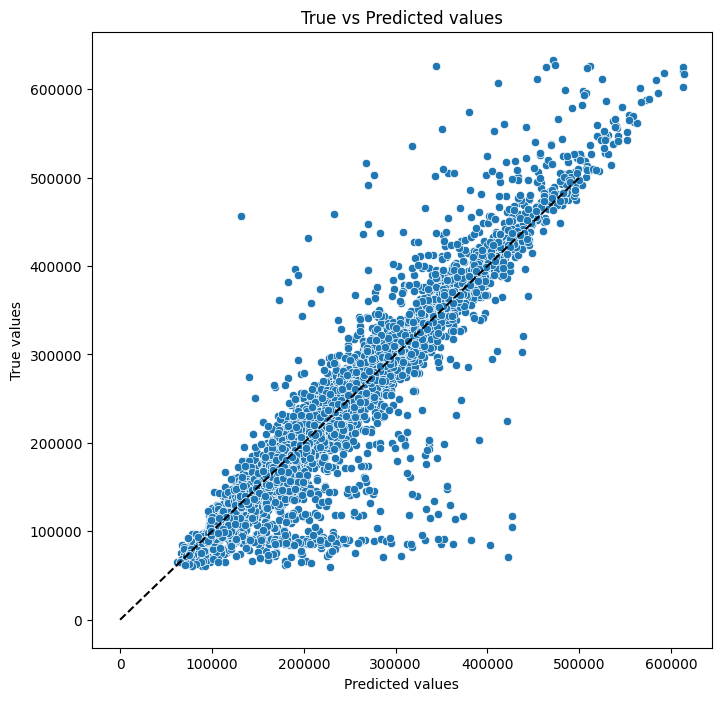

R2:	0.756
RMSE:	46320.487
MSE:	2145587535.112


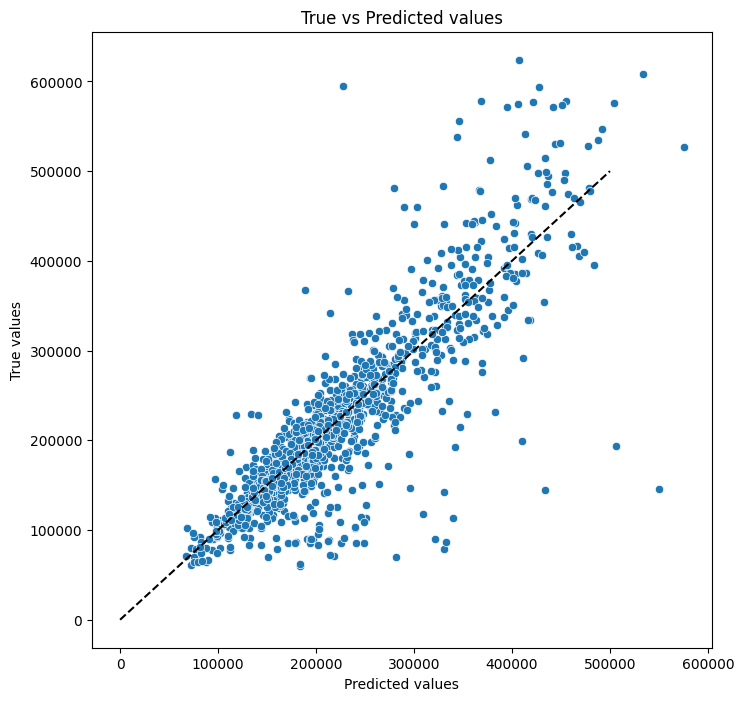

In [18]:
gbr = GradientBoostingRegressor(n_estimators=1600,
                                max_depth=6,
                                min_samples_leaf=10,
                                learning_rate=.02,
                                random_state=42,
                                criterion='friedman_mse',
                                max_features='sqrt', 
                                loss='huber',
                                )
gbr.fit(X_train, y_train.values.ravel())
y_train_preds = gbr.predict(X_train)
y_test_preds = gbr.predict(X_test)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)
evaluate_preds(np.squeeze(y_test.values), y_test_preds)

In [19]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gbr.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
19,DistrictPrice,0.217336
3,LifeSquare,0.192660
2,Square,0.165200
1,Rooms,0.073952
12,Social_2,0.061193
4,KitchenSquare,0.039737
11,Social_1,0.038492
13,Social_3,0.033768
7,HouseYear,0.028756
0,DistrictId,0.027352


In [20]:
predictions = pd.DataFrame(gbr.predict(test_df),
                           index=test_df.index)

In [21]:
predictions

,0
Id,
725,157467.333608
15856,232957.505796
5480,302063.235054
15664,328674.822684
14275,143847.000962
...,...
8180,257068.879260
4695,133325.642868
5783,342338.819943


In [22]:
predictions.to_csv('predict_test.csv')
